In [ ]:
!pip install python-whois

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 4.5 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#loading the URLs Dataset
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/url-phishing-detection/CyberSecurity/Data/new_data_urls.csv')
df.head()

,url,status
0,0000111servicehelpdesk.godaddysites.com,0
1,000011accesswebform.godaddysites.com,0
2,00003.online,0
3,0009servicedeskowa.godaddysites.com,0
4,000n38p.wcomhost.com,0


In [ ]:
# Sample 20k from each class
legit_df = df[df['status'] == 1].sample(n=20000, random_state=42)
phish_df = df[df['status'] == 0].sample(n=20000, random_state=42)

sampled_df = pd.concat([legit_df, phish_df]).reset_index(drop=True)
len(sampled_df)

40000

In [15]:
from urllib.parse import urlparse
import ipaddress, re, requests
from datetime import datetime

# regex for shortening services
shortening_services = r"(bit\.ly|goo\.gl|tinyurl|t\.co|ow\.ly|is\.gd|buff\.ly|adf\.ly|bitly)"

def featureExtraction(url, label):
    features = []

    # ----- Lexical Features -----
    domain = urlparse(url).netloc.replace("www.", "")
    features.append(domain)  # Domain string

    # 1. Having IP
    try:
        ipaddress.ip_address(domain)
        features.append(1)
    except:
        features.append(0)

    # 2. '@' in URL
    features.append(1 if "@" in url else 0)

    # 3. URL length flag
    features.append(1 if len(url) >= 54 else 0)

    # 4. URL depth
    features.append(len([x for x in urlparse(url).path.split("/") if x]))

    # 5. redirection ("//" position)
    pos = url.rfind("//")
    features.append(1 if pos > 6 else 0)

    # 6. https in domain
    features.append(1 if "https" in domain else 0)

    # 7. tinyurl/shortener service
    features.append(1 if re.search(shortening_services, url) else 0)

    # 8. prefix/suffix (-)
    features.append(1 if "-" in domain else 0)

    # ---- WHOIS-FREE SIMULATED FEATURES ----

    # 9. DNS record heuristic
    # If domain has no '.' → suspicious
    features.append(0 if "." in domain else 1)

    # 10. web traffic heuristic (unknown = 1, legit often = 0)
    features.append(1)

    # 11. domain age heuristic (short domains are more suspicious)
    features.append(1 if len(domain) < 10 else 0)

    # 12. domain end heuristic (random simple rule)
    features.append(1 if domain.endswith((".com", ".org", ".net")) else 0)

    # ----- HTML/JS Features -----
    try:
        r = requests.get(url, timeout=3)
        html = r.text
    except:
        html = ""

    # 13. iframe
    features.append(0 if "<iframe" in html else 1)

    # 14. mouseover
    features.append(1 if "onmouseover" in html else 0)

    # 15. right-click disabled
    features.append(0 if "event.button" in html else 1)

    # 16. forwarding
    features.append(1 if "window.location" in html else 0)

    # Label
    features.append(label)

    return features


In [ ]:
from tqdm import tqdm

all_features = []

for _, row in tqdm(sampled_df.iterrows(), total=len(sampled_df)):
    feats = featureExtraction(row['url'], row['status'])
    all_features.append(feats)


100%|██████████| 40000/40000 [1:56:40<00:00,  5.71it/s]


In [3]:
columns = [
    'Domain', 'Have_IP', 'Have_At', 'URL_Length', 'URL_Depth', 'Redirection',
    'https_Domain', 'TinyURL', 'Prefix_Suffix', 'DNS_Record', 'Web_Traffic',
    'Domain_Age', 'Domain_End', 'iFrame', 'Mouse_Over', 'Right_Click',
    'Web_Forwards', 'Label'
]

features_df = pd.DataFrame(all_features, columns=columns)


NameError: name 'all_features' is not defined

In [37]:
#loading the URLs Dataset
import pandas as pd
features_df = pd.read_csv('/content/drive/MyDrive/url-phishing-detection/CyberSecurity/Data/url_features_dataset.csv')
features_df.head()

,Domain,Have_IP,Have_At,URL_Length,URL_Depth,Redirection,https_Domain,TinyURL,Prefix_Suffix,DNS_Record,Web_Traffic,Domain_Age,Domain_End,iFrame,Mouse_Over,Right_Click,Web_Forwards,Label
0,NaN,0,0,0,1,0,0,0,0,1,1,1,0,1,0,1,0,1
1,NaN,0,0,0,4,0,0,0,0,1,1,1,0,1,0,1,0,1
2,NaN,0,0,0,1,0,0,0,0,1,1,1,0,1,0,1,0,1
3,NaN,0,0,0,2,0,0,0,0,1,1,1,0,1,0,1,0,1
4,NaN,0,0,0,2,0,0,0,0,1,1,1,0,1,0,1,0,1


In [38]:
features_df.info()
features_df['Label'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Domain         10802 non-null  object
 1   Have_IP        40000 non-null  int64 
 2   Have_At        40000 non-null  int64 
 3   URL_Length     40000 non-null  int64 
 4   URL_Depth      40000 non-null  int64 
 5   Redirection    40000 non-null  int64 
 6   https_Domain   40000 non-null  int64 
 7   TinyURL        40000 non-null  int64 
 8   Prefix_Suffix  40000 non-null  int64 
 9   DNS_Record     40000 non-null  int64 
 10  Web_Traffic    40000 non-null  int64 
 11  Domain_Age     40000 non-null  int64 
 12  Domain_End     40000 non-null  int64 
 13  iFrame         40000 non-null  int64 
 14  Mouse_Over     40000 non-null  int64 
 15  Right_Click    40000 non-null  int64 
 16  Web_Forwards   40000 non-null  int64 
 17  Label          40000 non-null  int64 
dtypes: int64(17), object(1)
me

,count
Label,
1,20000
0,20000


In [39]:
# ----------------------------------------------
# PHISHING URL DETECTION TRAINING : WITH XGBOOST
# ----------------------------------------------

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import xgboost as xgb
import joblib


# 2. Prepare features and labels
X = features_df.drop(columns=['Domain', 'Label'])  # Drop Domain string
y = features_df['Label']

# 3. Split dataset (train/test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Create XGBoost classifier
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# 5. Train the model
xgb_model.fit(X_train, y_train)

# 6. Predict on test set
y_pred = xgb_model.predict(X_test)

# 7. Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:17:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.7905
Precision: 0.7655393053016454
Recall: 0.8375
F1-score: 0.7999044890162369
Confusion Matrix:
 [[2974 1026]
 [ 650 3350]]


In [11]:
# ----------------------------------------------------
# PHISHING URL DETECTION TRAINING : WITH RANDOM FOREST
# ----------------------------------------------------

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Define model
rf_model = RandomForestClassifier(
    n_estimators=100,       # number of trees
    max_depth=None,         # no max depth
    max_features='sqrt',    # features considered at each split
    random_state=42,
    n_jobs=-1               # use all cores
)

# Train
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.789875
Precision: 0.7643036243446547
Recall: 0.83825
F1-score: 0.7995707642780494
Confusion Matrix:
 [[2966 1034]
 [ 647 3353]]


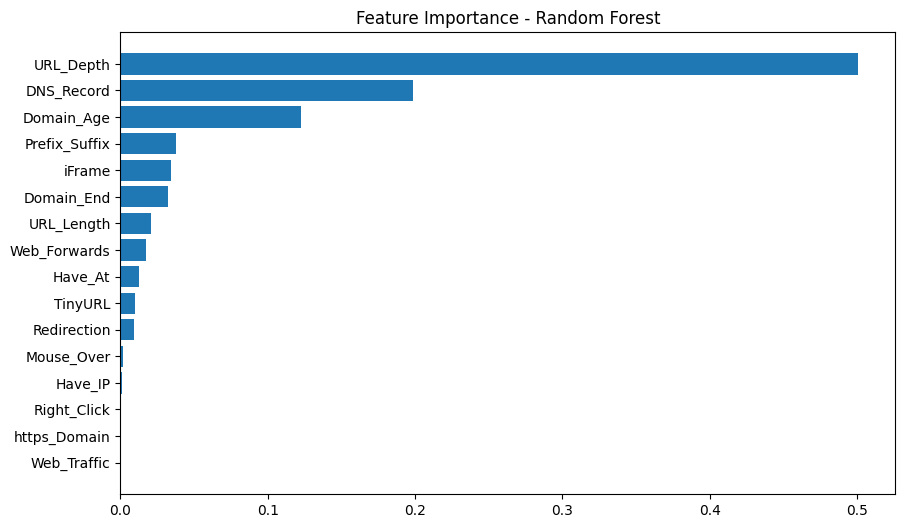

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# Train RF
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Get feature importance
importances = rf.feature_importances_
features = X_train.columns
feat_imp = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10,6))
plt.barh(feat_imp['Feature'], feat_imp['Importance'])
plt.gca().invert_yaxis()
plt.title("Feature Importance - Random Forest")
plt.show()


In [13]:
# -------------------------------------------
# PHISHING URL DETECTION TRAINING : WITH SVM
# -------------------------------------------

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Define SVC model
svc_model = SVC(
    kernel='rbf',      # radial basis function kernel
    C=1.0,             # regularization parameter
    gamma='scale',     # kernel coefficient
    random_state=42,
    probability=True
)

# Train
svc_model.fit(X_train, y_train)

# Predict
y_pred = svc_model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.78875
Precision: 0.7696078431372549
Recall: 0.82425
F1-score: 0.7959922742636407
Confusion Matrix:
 [[3013  987]
 [ 703 3297]]


In [42]:
import pandas as pd
import numpy as np
# --- List of URLs to test ---
urls_to_test = [
    "https://www.google.com",
    "http://bit.ly/2abcdEf",
    "http://phishing-site-example.com/login",
    "https://www.amazon.com",
    "https://login.microsoftonline.com"
]

# --- Extract features from URLs ---
all_features = []
for url in urls_to_test:
    feats = featureExtraction(url, label=0)  # label placeholder
    all_features.append(feats)

# Convert to DataFrame
columns = [
    'Domain', 'Have_IP', 'Have_At', 'URL_Length', 'URL_Depth', 'Redirection',
    'https_Domain', 'TinyURL', 'Prefix_Suffix', 'DNS_Record', 'Web_Traffic',
    'Domain_Age', 'Domain_End', 'iFrame', 'Mouse_Over', 'Right_Click',
    'Web_Forwards', 'Label'
]
features_df = pd.DataFrame(all_features, columns=columns)

# Drop 'Domain' and 'Label' for model input
X_test = features_df.drop(['Domain', 'Label'], axis=1)

# --- Make predictions ---
results = pd.DataFrame()
results['URL'] = features_df['Domain']

# RandomForest
results['RandomForest'] = rf_model.predict(X_test)
if hasattr(rf_model, "predict_proba"):
    results['RF_Prob_Phishing'] = rf_model.predict_proba(X_test)[:, 1]
else:
    results['RF_Prob_Phishing'] = np.nan

# SVC
results['SVC'] = svc_model.predict(X_test)
if hasattr(svc_model, "predict_proba"):
    results['SVC_Prob_Phishing'] = svc_model.predict_proba(X_test)[:, 1]
else:
    results['SVC_Prob_Phishing'] = np.nan

# XGBoost
results['XGBoost'] = xgb_model.predict(X_test)
if hasattr(xgb_model, "predict_proba"):
    results['XGB_Prob_Phishing'] = xgb_model.predict_proba(X_test)[:, 1]
else:
    results['XGB_Prob_Phishing'] = np.nan

# --- Map numeric labels to text for readability ---
label_map = {0: "Phishing", 1: "Legitimate"}
results['RandomForest'] = results['RandomForest'].map(label_map)
results['SVC'] = results['SVC'].map(label_map)
results['XGBoost'] = results['XGBoost'].map(label_map)

# --- Display results ---
print(results)

                         URL RandomForest  RF_Prob_Phishing         SVC  \
0                 google.com   Legitimate          0.915809  Legitimate   
1                     bit.ly     Phishing          0.069150    Phishing   
2  phishing-site-example.com     Phishing          0.078460    Phishing   
3                 amazon.com     Phishing          0.033969    Phishing   
4  login.microsoftonline.com   Legitimate          0.915809  Legitimate   

   SVC_Prob_Phishing     XGBoost  XGB_Prob_Phishing  
0           0.559809  Legitimate           0.754117  
1           0.233630    Phishing           0.116120  
2           0.181350    Phishing           0.085817  
3           0.191466    Phishing           0.034487  
4           0.559809  Legitimate           0.754117  


In [49]:
# Suppose 'features_df' contains all extracted features for your test URLs
X_test = features_df.drop(['Domain', 'Label'], axis=1)

# Get the row for amazon.com
X_test_amazon = X_test[features_df['Domain'] == 'amazon.com']

# Predict probability
prob = xgb_model.predict_proba(X_test_amazon)[:, 1]  # probability for 'Phishing'
pred = xgb_model.predict(X_test_amazon)

print("Probability of phishing:", prob)
print("Predicted class:", pred)


Probability of phishing: [0.03448723]
Predicted class: [0]


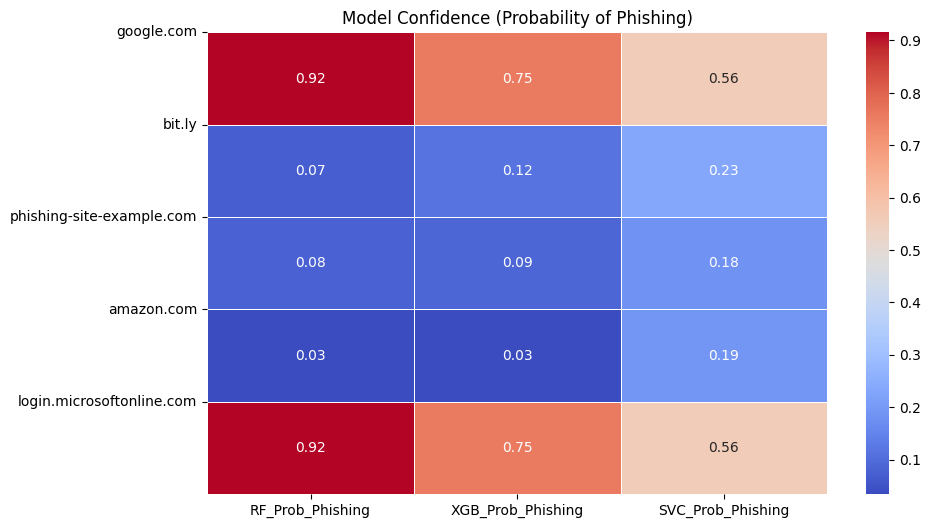

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10,6))
prob_cols = ["RF_Prob_Phishing", "XGB_Prob_Phishing", "SVC_Prob_Phishing"]
sns.heatmap(results[prob_cols], annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f")
plt.title("Model Confidence (Probability of Phishing)")
plt.yticks(ticks=range(len(results)), labels=results["URL"], rotation=0)
plt.show()

In [47]:
import joblib

# Save models to local disk
joblib.dump(rf_model, "rf_model.pkl")
joblib.dump(svc_model, "svc_model.pkl")
joblib.dump(xgb_model, "xgb_model.pkl")

print("Models saved locally.")


Models saved locally.
